## **Structured Report Generation**

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
NVIDIA_API_KEY=os.getenv("NVIDIA_API_KEY")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY=os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT=os.getenv("LANGSMITH_PROJECT")
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"

In [3]:
from tavily import TavilyClient, AsyncTavilyClient
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

In [4]:
# from langchain_google_genai import GoogleGenerativeAIEmbeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# from langchain_google_genai import ChatGoogleGenerativeAI
# llm1 = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [5]:
'''from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")'''
# from langchain_groq import ChatGroq
# import os
# llm=ChatGroq(model_name="Gemma2-9b-It")

'from langchain_huggingface import HuggingFaceEmbeddings\nembeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")'

In [25]:
from langchain_openai import ChatOpenAI
import os
llm = ChatOpenAI(model="gpt-4o-mini")

#llm = ChatOpenAI(base_url="http://localhost:8000/v1", model="gpt-4o-mini")

from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-08-01-preview",
    model="gpt-4o-mini",
    azure_endpoint=os.getenv("AZURE_OPENAI_API_BASE_CHAT")
)


In [109]:
#from langchain_groq import ChatGroq
# from langchain_google_genai import ChatGoogleGenerativeAI
# connect to an embedding NIM running at localhost:8000, specifying a model
# llm = ChatGroq(base_url="http://localhost:8000/v1", model="Gemma2-9b-It")
# llm1 = ChatGoogleGenerativeAI(base_url="http://localhost:8000/v1", model="gemini-1.5-pro")

**Writing Report Plan**

Creating Utils Functions

Next, you will create Utility functions that will be used for web research during report generation.

In [26]:
import asyncio
from langsmith import traceable
from pydantic import BaseModel, Field

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    ) 

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research: 
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

@traceable
def tavily_search(query):
    """ Search the web using the Tavily API.
    
    Args:
        query (str): The search query to execute
        
    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""
     
    return tavily_client.search(query, 
                         max_results=5, 
                         include_raw_content=True)

@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """
    
    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs

Planning

First, let's define the Schema for report sections.

In [27]:
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
  
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query for web search."
    )
class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

In [28]:
# Now you will define the LangGraph state. Each state will have the following fields.
import operator

class ReportState(TypedDict):
    topic: str # Report topic
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    report_structure: str # Report structure
    number_of_queries: int # Number web search queries to perform per section    
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

In [32]:
# Next you will write the report planner instructions, and a function that will generate the report sections.
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt to generate a search query to help with planning the report outline
report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report. 

The report will be focused on the following topic:

{topic}

The report structure will follow these guidelines:

{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections. 

The query should:

1. Be related to the topic 
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure."""

# Prompt generating the report outline
report_planner_instructions="""You are an expert technical writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report. 

The overall topic of the report is:

{topic}

The report should follow this organization: 

{report_organization}

You should reflect on this information to plan the sections of the report: 

{context}

Now, generate the sections of the report. Each section should have the following fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web research. For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

async def generate_report_plan(state: ReportState):

    # Inputs
    topic = state["topic"]
    report_structure = state["report_structure"]
    number_of_queries = state["number_of_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Generate search query
    structured_llm = llm.with_structured_output(Queries)
    
    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)
    
    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])
    
    # Web search
    query_list = [query.search_query for query in results.queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=True)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str)

    # Generate sections 
    structured_llm = llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])
    
    return {"sections": report_sections.sections}

In [35]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)
   
3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

Finally, choose the topic of your report. The default is CPU vs. GPU, but feel free to change the topic to something of your interest.

In [36]:
# Topic 
report_topic = "India overtake Japan as the world's fourth-largest economy impact on world markets and geopolitics"

In [37]:
# Let's run the agent. We set the Tavily topic to "general", but you can set it to "news" if you want Tavily to retrieve latest searches.

# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

# Generate report plan
sections = await generate_report_plan({"topic": report_topic, "report_structure": report_structure, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

# Print sections
for section in sections['sections']:
    print(f"{'='*50}")
    print(f"Name: {section.name}")
    print(f"Description: {section.description}")
    print(f"Research: {section.research}")

Name: Introduction
Description: This section provides a brief overview of India's economic milestone of overtaking Japan as the world's fourth-largest economy, highlighting the significance of this event within the global economic context and setting the stage for further comparative analysis.
Research: False
Name: India's Economic Context
Description: This section examines the core features of India's economy, detailing its rapid growth, demographic advantages, and structural reforms that have contributed to its rise. It will also outline the architecture and implementation of economic policies supporting this ascent.
Research: True
Name: Japan's Economic Status
Description: This section analyzes the characteristics of Japan's economy, focusing on the challenges it faces such as structural hurdles, demographic decline, and stagnation. It will provide insights into Japan's economic framework and historical significance in the global market.
Research: True
Name: Comparative Economic Ana

Research and Writing

Now you are ready to give the Agent details about which sections require research, and the number of queries needed. Let's First you will define the LangGraph state. Each state will have the following fields.

Let's define the LangGraph state. Each state will have the following fields:

In [38]:
class SectionState(TypedDict):
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    number_of_queries: int # Number web search queries to perform per section 
    section: Section # Report section   
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

Write Single Section

Now you will define the query writer instructions and the Agent function and nodes.

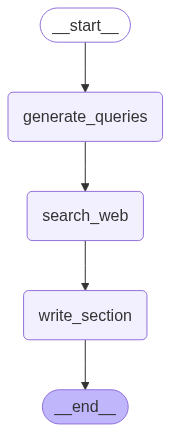

In [39]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

# Query writer instructions
query_writer_instructions="""Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material to help write the section:
{context}

5. Quality Checks:
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end"""

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state 
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries 
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))

Validate Single Section

Call on the Agent to write a single section to ensure the content is generated as expected.

In [40]:
# Test with one section
sections = sections['sections'] 
test_section = sections[1]
print(f"{'='*50}")
print(f"Name: {test_section.name}")
print(f"Description: {test_section.description}")
print(f"Research: {test_section.research}")

# Run
report_section = await section_builder_graph.ainvoke({"section": test_section, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

Name: India's Economic Context
Description: This section examines the core features of India's economy, detailing its rapid growth, demographic advantages, and structural reforms that have contributed to its rise. It will also outline the architecture and implementation of economic policies supporting this ascent.
Research: True


In [41]:
from IPython.display import Markdown
section = report_section['completed_sections'][0]
Markdown(section.content)

## Core Features of India’s Economy

**India is projected to become the third-largest economy by 2030, driven by demographic advantages and robust structural reforms.** Supported by a real GDP growth estimate of 6.4% for FY25, the economy leverages a substantial youth demographic, with 65% of its population under 35 years old (source: Ministry of Information and Broadcasting, 2024). 

Key initiatives such as "Make in India" and the "Production Linked Incentive" schemes enhance the manufacturing sector, contributing 17-18% to GDP (source: IBEF, 2025). In FY25, total exports are expected to reach ₹69.8 lakh crore (US$820.9 billion), underlining India’s expanding global reach (source: IBEF, 2025).

India's digital economy is also on a growth trajectory, exemplified by the Unified Payments Interface (UPI) processing nearly ₹81 lakh crore in transactions for April to July 2024 (source: Ministry of Information and Broadcasting, 2024). These elements combine to create a resilient macroeconomic framework while addressing inflationary pressures and promoting sustainable development.

### Sources
- Here are key takeaways from Economic Survey 2024-2025 - Down To Earth: https://www.downtoearth.org.in/economy/here-are-key-takeaways-from-economic-survey-2024-2025
- India's Exceptional Growth Trajectory: A Multi-Sectoral Overview A Promising Future Driven by Youth and Innovation: https://static.pib.gov.in/WriteReadData/specificdocs/documents/2024/sep/doc2024927403201.pdf
- Indian Economy Growth Rate, GDP & Economic Structure Insights - IBEF: https://www.ibef.org/economy/indian-economy-overview
- Comprehensive Economic Analysis of India: 2025 Perspective: https://aria.org.in/article/comprehensive-economic-analysis-of-india-2025-perspective/

Write All Sections

In [42]:
class ReportStateOutput(TypedDict):
    final_report: str # Final report

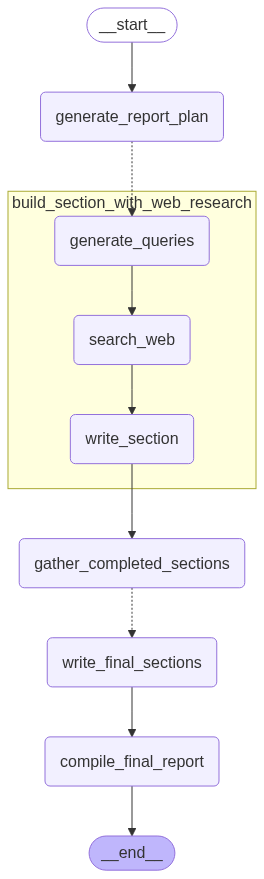

In [43]:
from langgraph.constants import Send

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Section to write: 
{section_topic}

Available report content:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports: 
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response"""

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """    
    
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s, 
                                                 "number_of_queries": state["number_of_queries"], 
                                                 "tavily_topic": state["tavily_topic"], 
                                                 "tavily_days": state.get("tavily_days", None)}) 
        for s in state["sections"] 
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state 
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges 
builder = StateGraph(ReportState, output=ReportStateOutput)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [45]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)
   
3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations
5. Include the text: "Created by Divakar Kumar" at the bottom of the report. """

# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

In [46]:
# Topic 
report_topic = "India overtake Japan as the world's fourth-largest economy impact on world markets and geopolitics"

In [47]:
report = await graph.ainvoke({"topic": report_topic, "report_structure": report_structure, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

In [48]:
from IPython.display import Markdown
Markdown(report['final_report'])

# India's Economic Rise and Its Global Significance

This section provides a brief overview of India's economic growth and its recent rise to become the world's fourth-largest economy, surpassing Japan. India's GDP growth, fueled by a youthful population, government initiatives, and a thriving services sector, has positioned it as a key player in global markets. Meanwhile, Japan faces challenges with an aging demographic and stagnant growth. This comparative analysis underscores how India's surge not only changes the economic landscape but also has far-reaching implications for global trade dynamics and geopolitical relations, particularly in the context of a shifting balance of power in the Indo-Pacific region. Understanding these factors is vital for stakeholders navigating the new economic order.

## India's Economic Characteristics

**India is poised for sustained economic growth, projected at 6.5-7% for FY 2024-25.** This growth trajectory is bolstered by vibrant sectors such as agriculture, construction, and services. In Q4 FY 2024-25, GDP growth accelerated to 7.4%, principally driven by a robust agriculture sector expanding at 4.6% and construction registering an impressive 10.8% growth (DNA India, 2025).

Key growth factors include demographic advantages, with over 65% of the population under 35 years of age, positioned to drive consumer demand and innovation (S&P Global, 2024). Government initiatives like the Production Linked Incentive (PLI) Scheme aim to enhance manufacturing capabilities across various sectors, ultimately fostering foreign direct investment (IBEF, 2025).

The Economic Survey 2024-25 highlights government spending on infrastructure, with capital expenditure growing by 28.2% year-on-year, as vital for sustaining growth (Press Information Bureau, 2024). This combination of demographic potential and strategic government policies has firmly positioned India as one of the fastest-growing economies globally.

### Sources
- Major boost for Indian economy as GDP growth recorded at 6.5% in FY 2024-25 : https://www.dnaindia.com/india/report-indian-economy-fourth-largest-economy-gdp-growth-recorded-at-65-percent-in-fy-2024-25-q4-growth-beats-forecast-to-reach-74-percent-business-news-pm-modi-niti-aayog-agriculture-construction-imf-data-3155581
- Economic Survey 2024-25: Summary, Key Highlights & Insights : https://www.insightsonindia.com/2025/02/01/economic-survey-2024-25-summary/
- Indian Economy 2024: GDP, FDI, Trade Trends : https://www.india-briefing.com/news/india-economy-2024-gdp-growth-rate-fdi-trade-performance-35614.html/
- Press Information Bureau : https://pib.gov.in/PressNoteDetails.aspx?NoteId=153213&ModuleId=3

## Economic Structure of Japan

**Japan faces significant economic challenges due to its aging population and declining workforce, impacting its competitive positioning globally.** As of 2023, more than 30% of the population is over the age of 65, projected to rise to approximately 40% by 2060 (Mitsui & Co. Global Strategic Studies Institute). This demographic shift threatens productivity and increases demand for healthcare and pensions, which are projected to further strain public finances (World Economic Forum).

Simultaneously, Japan remains the third-largest economy globally, leveraging its technological advancements, particularly in robotics and automation, to address labor shortages. For instance, Komatsu developed teleoperated excavators to enhance construction efficiency amid a labor crunch (Japan Finds Innovative Solutions to Counter Its Aging Headwind). The economy's reliance on technology is essential not only for maintaining output but also for innovating across sectors including agriculture, where robots are being used to automate rice cultivation, significantly increasing yields (Japan Finds Innovative Solutions to Counter Its Aging Headwind).

### Sources
- Mitsui & Co. Global Strategic Studies Institute, Monthly Report July 2023: https://www.mitsui.com/mgssi/en/report/detail/__icsFiles/afieldfile/2023/08/30/2307k_suzuki_e_2.pdf
- World Economic Forum, "Japan's ageing population: The implications for its economy," September 2023: https://www.weforum.org/stories/2023/09/elderly-oldest-population-world-japan/
- Japan Finds Innovative Solutions to Counter Its Aging Headwind: https://emag.directindustry.com/2024/03/14/japan-finds-innovative-solutions-to-counter-its-aging-headwind/

## Comparative Analysis of India and Japan's Economies

**India has surpassed Japan to become the world's fourth-largest economy, yet it faces significant challenges in per capita income.** As of 2024, India's nominal GDP reached approximately USD 3.91 trillion, compared to Japan's USD 4.196 trillion. However, India’s GDP per capita stands at about USD 2,500, starkly lower than Japan’s USD 34,000. The International Monetary Fund (IMF) projects that India's GDP is on track to grow at 6.5% in 2025, while Japan's growth rate is forecasted at merely 1.1%.

Key drivers for India’s economic expansion include:
- A young and dynamic population.
- Rapid digital transformation and manufacturing initiatives like "Make in India."
- Strong domestic consumption and infrastructure development.

In contrast, Japan grapples with structural issues, including an aging population and stagnant growth. This demographic challenge hinders its ability to sustain robust economic performance. For instance, Japan’s economy has not substantially changed in the last two decades, emphasizing the importance of reform and adaptability in light of shifting global economic dynamics.

### Sources
- India Surpasses Japan to Become World's Fourth-Largest Economy: The ...: https://www.republicworld.com/business/india-overtakes-japan-a-comparison-of-two-economies
- Country comparison India vs Japan 2025 - countryeconomy.com: https://countryeconomy.com/countries/compare/india/japan
- India Overtakes Japan In GDP But Per Capita Income Still ... - News18: https://www.news18.com/business/india-overtakes-japan-in-gdp-but-per-capita-income-still-matters-heres-why-ws-dkl-9353657.html
- Beyond the buzz: Has India really surpassed Japan to become the ... - Mint: https://www.livemint.com/economy/india-gdp-ranking-india-overtakes-japan-india-vs-japan-economy-imf-world-economic-outlook-india-gdp-per-capita-11748253141230.html
- India vs Japan Economy Stats Compared - NationMaster: https://www.nationmaster.com/country-info/compare/India/Japan/Economy

## Geopolitical Ramifications of India's Economic Rise

**India's ascent to the world's fourth-largest economy significantly alters its geopolitical influence and trade dynamics.** As reported by the International Monetary Fund (IMF), India’s nominal GDP reached approximately $4.19 trillion in 2025, surpassing Japan's economic standing. This transition enhances India's leverage in international forums like the G20 and BRICS, allowing it to shape global economic policies more assertively.

India's rise catalyzes potential shifts in alliances and economic partnerships. For instance, increasing trade with key partnerships in the Global South, particularly under initiatives like "Make in India" and "Atmanirbhar Bharat," reflects a strategic pivot away from dependency on China. Furthermore, as tensions evolve, India is seen as a counterbalance to China in the Indo-Pacific region, echoing Western interests in diversifying supply chains.

* Key developments include:
  - Strengthened ties with the U.S. and EU for trade agreements.
  - Expansion of the role within ASEAN for regional trade stability.
  - Enhanced global investment as a reliable manufacturing hub.

To sustain growth, India must address issues such as income inequality and infrastructure challenges while maintaining a diplomatic balance amid shifting geopolitical landscapes.

### Sources
- India Surpassed Japan as the World’s Fourth Largest Economy : https://www.tekedia.com/india-surpassed-japan-as-the-worlds-fourth-largest-economy/
- India's Economic Journey: Milestones and Implications : https://unreadwhy.com/india-rises-to-4th-gdp-milestone-global-implications/
- India's Growing Global Influence: Trade Partnerships and Alliances : https://diplomatist.com/2024/12/13/indias-trade-agreements-and-economic-partnerships-building-stronger-ties-with-the-global-south/
- Beyond the Trade Wars: India's Role in a Fractured Order : https://kpmg.com/in/en/blogs/2025/05/beyond-the-trade-wars-indias-role-in-a-fractured-order.html

## Conclusion

This report presents a comparative analysis of India's and Japan's economies, highlighting distinct strengths and challenges faced by each country. The table below encapsulates key economic indicators and relevant characteristics, offering a clear juxtaposition of both nations.

| Dimension               | India                                   | Japan                                    |
|-------------------------|-----------------------------------------|------------------------------------------|
| GDP (2024)              | USD 3.91 trillion                       | USD 4.196 trillion                       |
| GDP Growth Rate (2025)  | 6.5%                                   | 1.1%                                     |
| GDP Per Capita          | USD 2,500                              | USD 34,000                              |
| Population (Aged 65+)   | <10% (2024)                            | 30% (2023), projected to 40% by 2060    |
| Key Growth Drivers       | Young demographic, digital transformation | Technological advancements, manufacturing |
| Major Challenges         | Income inequality, infrastructure gaps   | Aging population, stagnant growth         |

India's robust growth trajectory, fueled by an emerging young workforce and strategic initiatives, contrasts sharply with Japan's economic stagnation and demographic concerns. To fortify its position, India must focus on addressing socio-economic challenges while enhancing global trade partnerships. Both countries could benefit from adopting innovative policies that leverage their unique strengths to navigate the complexities of an evolving global economy.

In [49]:
#print the final report in plain text
report['final_report']

'# India\'s Economic Rise and Its Global Significance\n\nThis section provides a brief overview of India\'s economic growth and its recent rise to become the world\'s fourth-largest economy, surpassing Japan. India\'s GDP growth, fueled by a youthful population, government initiatives, and a thriving services sector, has positioned it as a key player in global markets. Meanwhile, Japan faces challenges with an aging demographic and stagnant growth. This comparative analysis underscores how India\'s surge not only changes the economic landscape but also has far-reaching implications for global trade dynamics and geopolitical relations, particularly in the context of a shifting balance of power in the Indo-Pacific region. Understanding these factors is vital for stakeholders navigating the new economic order.\n\n## India\'s Economic Characteristics\n\n**India is poised for sustained economic growth, projected at 6.5-7% for FY 2024-25.** This growth trajectory is bolstered by vibrant sect

In [50]:
import os

# 1. Set your folder path
folder_path = 'reports'

# 2. Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# 3. Define the full file path
file_path = os.path.join(folder_path, 'final_report.md')

# 4. Write the Markdown content into the file
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(report['final_report'])

print(f"Saved final_report.md to {file_path}")


Saved final_report.md to reports\final_report.md
